In [1]:
import galsim
import numpy as np

import ultraplot as uplot

## Spergel HLR

In [2]:
nu_vals = np.linspace(-0.85, 4.0, 500)
NU_FRAC = 0.5

frac_vals = []
for nu in nu_vals:
    prof = galsim.Spergel(nu, scale_radius=1)
    frac_vals.append(prof.calculateFluxRadius(NU_FRAC))

frac_vals = np.array(frac_vals)

/Users/beckermr/mambaforge/envs/jax-galsim/lib/python3.13/site-packages/ultraplot/__init__.py:84: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


<a list of 1 Line2D objects>

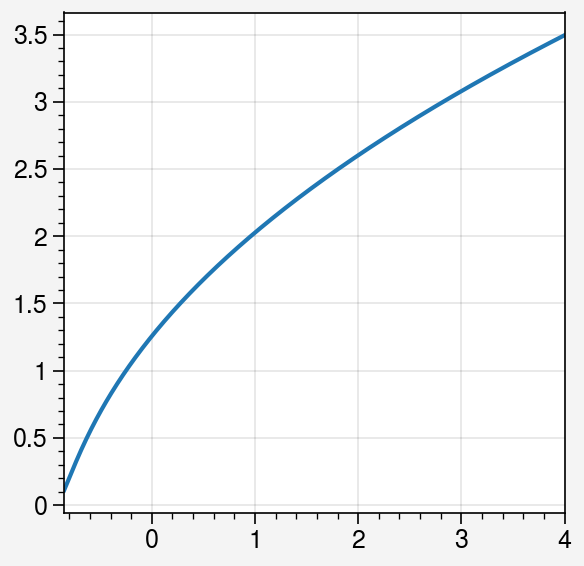

In [3]:
fig, axs = uplot.subplots()

axs.plot(nu_vals, frac_vals)

In [4]:
import scipy.optimize
import numpy.polynomial
from numpy.polynomial import Polynomial

numpy.polynomial.set_default_printstyle("ascii")

In [5]:
RATNL_ORDER = 9


def get_ratnl_func_polys(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)
    return pm, qm


def ratnl_func(x, *coeff):
    pm, qm = get_ratnl_func_polys(coeff)
    return pm(x) / qm(x)


res = scipy.optimize.curve_fit(
    ratnl_func, nu_vals, frac_vals, p0=np.ones(2 * RATNL_ORDER + 1), full_output=True
)

In [6]:
coeff = res[0]

pm, qm = get_ratnl_func_polys(coeff)

In [7]:
def make_poly_code(pm, head="", base_indent=0):
    res = ""
    indent = base_indent
    for c in pm.coef:
        if c == pm.coef[-1]:
            end = ""
        else:
            end = " + x * ("

        if c == pm.coef[0]:
            _hd = head
        else:
            _hd = ""
        res += " " * 4 * indent + f"{_hd}{c}{end}\n"
        if c != pm.coef[-1]:
            indent += 1

    for _ in pm.coef[:-1]:
        indent -= 1
        res += " " * 4 * indent + ")\n"

    return res


code = "def _spergel_hlr(x):\n"
code += make_poly_code(pm, head="pm = ", base_indent=1)
code += make_poly_code(qm, head="qm = ", base_indent=1)
code += "    return pm / qm"

print(code)

def _spergel_hlr(x):
    pm = 1.257151227888416 + x * (
        2.491448310111135 + x * (
            0.9179457311146969 + x * (
                -0.2594948340603504 + x * (
                    0.014652400666282825 + x * (
                        0.3745700706480111 + x * (
                            1.6477010509316423 + x * (
                                1.7251479066681694 + x * (
                                    0.5287965877452406 + x * (
                                        0.031910068051691706
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
    qm = 1.0 + x * (
        1.227880253971835 + x * (
            0.01345041492393974 + x * (
                -0.06732314014110657 + x * (
                    -0.0010427391400509856 + x * (
                        0.32156617664997633 + x * (
                            1.0510099079117354 +

1.2518623244700545e-07 9.881287840463049e-07
1.2518623244700545e-07 9.881287840463049e-07


<a list of 1 Line2D objects>

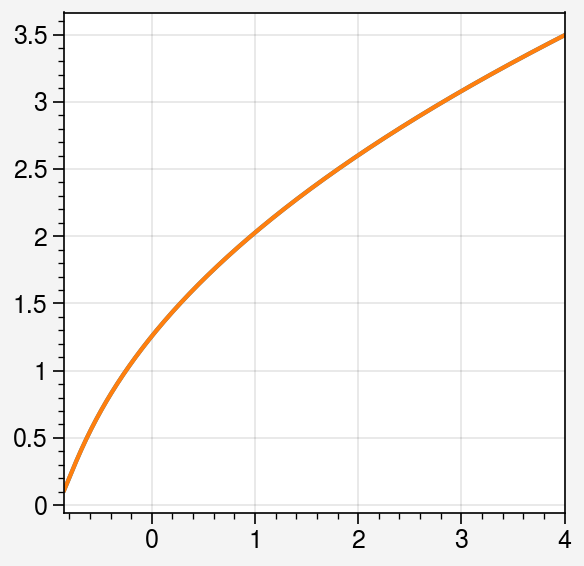

In [8]:
exec(code)

preds = _spergel_hlr(nu_vals)
diff = np.abs(frac_vals - preds)
print(np.mean(diff), np.max(diff))

preds = ratnl_func(nu_vals, *coeff)
diff = np.abs(frac_vals - preds)
print(np.mean(diff), np.max(diff))


fig, axs = uplot.subplots()

# axs.plot(nu_vals, hlr_vals)
axs.plot(nu_vals, frac_vals)
axs.plot(nu_vals, preds)

In [9]:
rng = np.random.RandomState()

diffs = []
nus = []
for _ in range(10000):
    nu = rng.uniform(low=-0.85, high=4.0)
    re = 1.0

    try:
        ival = _spergel_hlr(nu)
        tval = galsim.Spergel(nu, scale_radius=re).calculateFluxRadius(NU_FRAC)
    except Exception:
        pass
    else:
        diffs.append(ival - tval)
        nus.append(nu)

print(np.median(np.abs(diffs)), np.max(np.abs(diffs)), nus[np.argmax(np.abs(diffs))])

1.194337656551525e-07 1.0107681182591755e-06 -0.838950864969565


## Spergel Flux Radius Interp

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)

from functools import partial  # noqa: E402

import galsim  # noqa: E402
import jax.numpy as jnp  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
import numpy as np  # noqa: E402

In [ ]:
import scipy.special as spsp

EPS = 1e-3
NU_MIN = -0.85
NU_MAX = 4.0
FF_MIN = EPS
FF_MAX = 1.0 - EPS


# this is the function we are interpolating
@np.vectorize
def _fun(nu, flux_frac):
    prof = galsim.Spergel(nu, scale_radius=1)
    return prof.calculateFluxRadius(flux_frac)


n_nu = 200
n_ff = 200
_nus = np.linspace(NU_MIN, NU_MAX, n_nu)
_ffs = spsp.expit(np.linspace(spsp.logit(FF_MIN), spsp.logit(FF_MAX), n_ff))

nus = []
ffs = []
frs = []
for nu in _nus:
    for ff in _ffs:
        nus.append(nu)
        ffs.append(ff)
        frs.append(
            _fun(nu, ff)
        )
nus = jnp.array(nus)
ffs = jnp.array(ffs)
frs = jnp.array(frs).reshape(n_nu, n_ff)

In [ ]:
from jax_galsim.core.interpolate import akima_interp_coeffs, akima_interp, akima_interp2d
from interpax import interp2d

rng = np.random.default_rng()
n_test = 200000

tnus = rng.uniform(low=NU_MIN, high=NU_MAX, size=n_test)
tffs = spsp.expit(rng.uniform(low=spsp.logit(FF_MIN), high=spsp.logit(FF_MAX), size=n_test))
apprx = np.exp(akima_interp2d(spsp.logit(tffs), tnus, spsp.logit(_ffs), _nus, np.log(frs)))
# apprx = np.exp(interp2d(tnus, spsp.logit(tffs), _nus, spsp.logit(_ffs), np.log(frs), method="akima"))
true = []
for i in range(n_test):
    try:
        val = _fun(tnus[i], tffs[i])
    except Exception:
        val = np.nan
        print("failed:", tnus[i], tffs[i])
    true.append(val)
true = np.array(true)

msk = np.isfinite(true)
tnus = tnus[msk]
tffs = tffs[msk]
true = true[msk]
apprx = apprx[msk]

eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx / true - 1|"
print("maximum frac error:", c_func(eps))
ind = np.argmax(eps)
print("max loc:", tnus[ind], tffs[ind])


fig, ax = plt.subplots()
hb = ax.hexbin(
    tnus,
    spsp.logit(tffs),
    C=eps,
    reduce_C_function=c_func,
    extent=(NU_MIN, NU_MAX, spsp.logit(FF_MIN), spsp.logit(FF_MAX)),
    gridsize=50,
    bins="log",
)
ax.set_xlim(NU_MIN, NU_MAX)
ax.set_ylim(spsp.logit(FF_MIN), spsp.logit(FF_MAX))
ax.set_xlabel("nu")
ax.set_ylabel("logit(flux fraction)")
fig.colorbar(hb, label=eps_label)

In [ ]:
nui, ffi = -0.8421807776455345, 0.0010524902760193275

zvals = []
for i in range(n_nu):
    coeffs = akima_interp_coeffs(spsp.logit(_ffs), np.log(frs[i, :]))
    zvals.append(
        akima_interp(spsp.logit(ffi), spsp.logit(_ffs), np.log(frs[i, :]), coeffs)
    )

zvals = np.array(zvals)

coeffs = akima_interp_coeffs(_nus, zvals)
fri = np.exp(akima_interp(nui, _nus, zvals, coeffs))

print(
    fri,
    np.exp(interp2d(nui, spsp.logit(ffi), _nus, spsp.logit(_ffs), np.log(frs), method="akima")),
    np.exp(akima_interp2d(spsp.logit(ffi), nui, spsp.logit(_ffs), _nus, np.log(frs))),
    _fun(nui, ffi),
)

plt.plot(_nus, zvals)


## Spergel Flux Radius Psuedo-Pade

In [10]:
import jax

jax.config.update("jax_enable_x64", True)

from functools import partial  # noqa: E402

import galsim  # noqa: E402
import jax.numpy as jnp  # noqa: E402
import numpy as np  # noqa: E402
import ultraplot as uplt  # noqa: E402

In [ ]:
def _build_design_matrix(x, order):
    val = np.stack([
        x**o for o in range(order + 1)
    ], axis=-1)

    return val[:, ::-1]


def _fit_pseudo_pade(x, y, m, n, zero_val=None):
    pdes = _build_design_matrix(x, m)
    if zero_val is not None:
        pdes = pdes[:, :-1]
    qdes = -y.reshape(-1, 1) * _build_design_matrix(x, n)[:, :-1]
    des = np.concatenate([pdes, qdes], axis=1)
    if zero_val is not None:
        return np.linalg.lstsq(des, y - zero_val)[0]
    else:
        return np.linalg.lstsq(des, y)[0]


# @partial(jax.jit, static_argnames=("m", "n", "zero_val"))
# @partial(jnp.vectorize, excluded=(1, 2, 3, 4))
def _pade_func(x, coeffs, m, n, zero_val):
    if zero_val is not None:
        pcoeffs = jnp.concatenate([coeffs[:m], jnp.ones(1) * zero_val], axis=0)
        qcoeffs = jnp.concatenate([coeffs[m:], jnp.ones(1)], axis=0)
    else:
        pcoeffs = coeffs[:m + 1]
        qcoeffs = jnp.concatenate([coeffs[m + 1:], jnp.ones(1)], axis=0)

    jax.debug.print("p coeffs: {val}", val=pcoeffs)
    jax.debug.print("q coeffs: {val}", val=qcoeffs)
    return jnp.polyval(pcoeffs, x) / jnp.polyval(qcoeffs, x)


# rational function approximation for spergel HLR -> scale radius
# med abs error: 1.0971223929345797e-12
# max abs error: 6.051817105778845e-08
# RATIONAL_POLY_VALS is the array of rational function
# polynomial coefficients that define the approximation
# fmt: off
RATIONAL_POLY_VALS = np.array(
    [+1.9759469124408490e+04, +5.0711956245802976e+04, -3.0449791419192003e+04, -1.4117283167512303e+04,
     +6.8059252203919750e+04, +3.4622357459975698e+04, +4.6734418411048373e+03, +1.8889376861140292e+02,
     +2.5236212634931188e+00, -1.0073593043390322e+02, +3.8254304100058880e+03, +4.1107191856638208e+04,
     +2.1030308615008391e+04, -4.4014537849077409e+04, +3.3258091678020763e+04, +5.8994327909625252e+04,
     +1.7534519391360263e+04, +1.7474584540951789e+03, +6.7765143127010404e+01],
    dtype=np.float64,
)
# fmt: on

NU_MIN = -0.85
NU_MAX = 4.0
FR_MIN = 0.1121176556198992
FR_MAX = 3.4944869314199307
RATIONAL_POLY_M = 9
RATIONAL_POLY_N = 10
ZERO_VAL = 0.0


def _scale_nu(nu):
    r

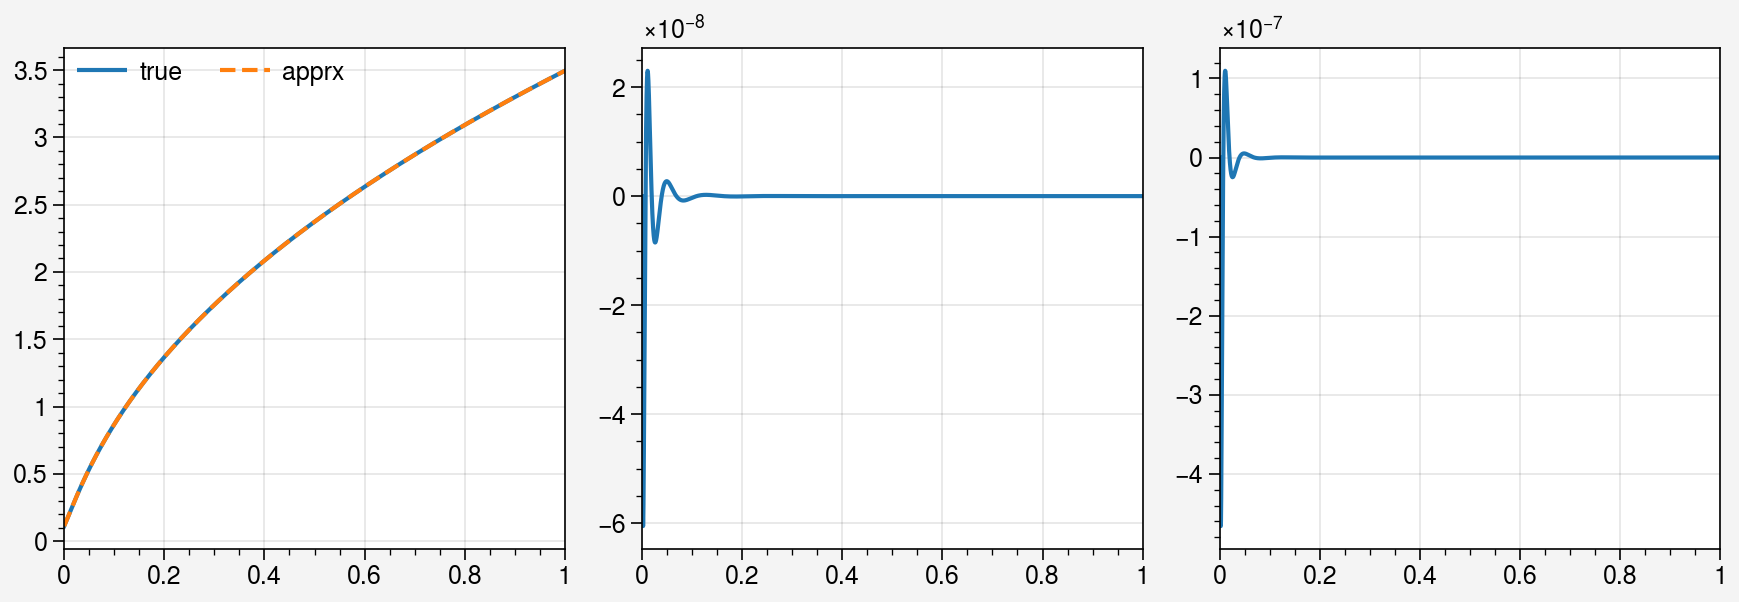

In [ ]:
# from scipy.special import expit, logit
import textwrap


# this is the function we are interpolating
@np.vectorize
def _fun(nu, flux_frac):
    try:
        prof = galsim.Spergel(nu, scale_radius=1)
        val = prof.calculateFluxRadius(flux_frac)
    except Exception:
        val = np.nan
    return val


ff = 0.5
NU_MIN = -0.85
NU_MAX = 4.0
EPS = 1e-5
FR_MAX = float(_fun(NU_MAX, ff))
FR_MIN = float(_fun(NU_MIN, ff))


def _scale_nu(nu):
    return (nu - NU_MIN) / (NU_MAX - NU_MIN)


def _unscale_nu(snu):
    return snu * (NU_MAX - NU_MIN) + NU_MIN


def _scale_fr(fr):
    return (fr - FR_MIN) / (FR_MAX - FR_MIN)


def _unscale_fr(sfr):
    return sfr * (FR_MAX - FR_MIN) + FR_MIN


ZERO_VAL = float(_scale_fr(FR_MIN))

assert _unscale_nu(_scale_nu(1.0)) == 1.0

seed = None
# nu = _unscale_nu(np.linspace(_scale_nu(NU_MIN), _scale_nu(NU_MAX), 100000))
nu = _unscale_nu(np.linspace(_scale_nu(NU_MIN), _scale_nu(NU_MAX), 500))
vals = _fun(nu, ff)
msk = np.isfinite(vals)
vals = vals[msk]
nu = nu[msk]

fit_nu = _scale_nu(nu)
fit_vals = _scale_fr(vals)

m = 9
n = m + 1
coeffs = _fit_pseudo_pade(fit_nu, fit_vals, m, n, zero_val=ZERO_VAL)
if ZERO_VAL is not None:
    assert coeffs.shape[0] == m + n
    assert _pade_func(0, coeffs, m, n, ZERO_VAL) == ZERO_VAL
    assert _pade_func(0, coeffs, m, n, ZERO_VAL) == ZERO_VAL
else:
    assert coeffs.shape[0] == m + n + 1

# print data
pstr = textwrap.indent(
    np.array2string(np.array(coeffs), floatmode="unique", threshold=100000000, separator=", ", max_line_width=120, sign="+"),
    "    ",
)

code_str = f"""\
# RATIONAL_POLY_VALS is the array of rational function
# polynomial coefficients that define the approximation
# fmt: off
RATIONAL_POLY_VALS = np.array(
{pstr},
    dtype=np.float64,
)
# fmt: on

NU_MIN = {NU_MIN}
NU_MAX = {NU_MAX}
FR_MIN = {FR_MIN}
FR_MAX = {FR_MAX}
RATIONAL_POLY_M = {m}
RATIONAL_POLY_N = {n}
ZERO_VAL = {ZERO_VAL}


def _scale_nu(nu):
    return (nu - NU_MIN) / (NU_MAX - NU_MIN)


def _unscale_fr(sfr):
    return sfr * (FR_MAX - FR_MIN) + FR_MIN


@partial(jax.jit, static_argnames=("m", "n", "zero_val"))
@partial(jnp.vectorize, excluded=(1, 2, 3, 4))
def _pade_func(x, coeffs, m, n, zero_val):
    if zero_val is not None:
        pcoeffs = jnp.concatenate([coeffs[:m], jnp.ones(1) * zero_val], axis=0)
        qcoeffs = jnp.concatenate([coeffs[m:], jnp.ones(1)], axis=0)
    else:
        pcoeffs = coeffs[: m + 1]
        qcoeffs = jnp.concatenate([coeffs[m + 1 :], jnp.ones(1)], axis=0)
    return jnp.polyval(pcoeffs, x) / jnp.polyval(qcoeffs, x)


@jax.jit
@jnp.vectorize
def _spergel_hlr_pade(nu):
    \"\"\"A Pseudo-Pade approximation for the HLR of the Spergel profile as a function of nu.\"\"\"
    return _unscale_fr(
        _pade_func(
            _scale_nu(nu),
            RATIONAL_POLY_VALS,
            RATIONAL_POLY_M,
            RATIONAL_POLY_N,
            ZERO_VAL,
        )
    )
"""

exec(code_str)

nu = _unscale_nu(np.linspace(_scale_nu(NU_MIN), _scale_nu(NU_MAX), 100000))
vals = _fun(nu, ff)
msk = np.isfinite(vals)
vals = vals[msk]
nu = nu[msk]

apprx = _spergel_hlr_pade(nu)


fig, axs = uplt.subplots(ncols=3, nrows=1, sharey=0)
ax = axs[0]
ax.plot(_scale_nu(nu), vals, label="true")
ax.plot(_scale_nu(nu), apprx, label="apprx", linestyle="dashed")
ax.legend(loc="ul", frameon=False)

ax = axs[1]
ax.plot(_scale_nu(nu), apprx - vals)

ax = axs[2]
ax.plot(_scale_nu(nu), apprx / vals - 1)


print("# rational function approximation for spergel HLR -> scale radius")
print("# med abs error:", np.median(np.abs(apprx - vals)))
print("# max abs error:", np.max(np.abs(apprx - vals)))
print(code_str)


In [ ]:
import jax.scipy.special as jspsp
import scipy.special as spsp

# order of rational function in flux fraction, nu
PADE_ORDERS = [5, 5]

N_PARAMS_FF = PADE_ORDERS[0] * 2 - 1
N_PARAMS_NU = PADE_ORDERS[1] * 2 - 1
N_PARAMS = N_PARAMS_NU * N_PARAMS_FF

EPS = 1e-6
NU_MIN = -0.85
NU_MAX = 4.0
FF_MIN = EPS
FF_MAX = 1.0 - EPS


# this is the function we are interpolating
@np.vectorize
def _fun(nu, flux_frac):
    try:
        prof = galsim.Spergel(nu, scale_radius=1)
        val = prof.calculateFluxRadius(flux_frac)
    except Exception:
        val = np.nan
    return val


n_nu = 100
n_ff = 100
_nus = np.linspace(NU_MIN, NU_MAX, n_nu)
_ffs = spsp.expit(np.linspace(spsp.logit(FF_MIN), spsp.logit(FF_MAX), n_ff))

nus = []
ffs = []
frs = []
for nu in _nus:
    for ff in _ffs:
        nus.append(nu)
        ffs.append(ff)
        frs.append(
            _fun(nu, ff)
        )
nus = jnp.array(nus)
ffs = jnp.array(ffs)
frs = jnp.array(frs)


FRS_MIN = float(np.min(frs))
FRS_MAX = float(np.max(frs))


def _pade_func(coeffs, x, order):
    p = jnp.polyval(coeffs[:order], x)
    q = jnp.polyval(
        jnp.concatenate([coeffs[order:], jnp.ones(1)], axis=0),
        x,
    )
    return p / q


def test_pade_func():
    order = 3
    coeffs = np.zeros(2 * order - 1)
    x = 1.0
    assert _pade_func(coeffs, x, order) == 0.0

    order = 2
    coeffs = np.array([0.1, 0.2, 0.4])
    x = -0.4
    assert _pade_func(coeffs, x, order) == (0.1 * x + 0.2) / (1.0 + 0.4 * x)

    order = 3
    coeffs = np.array([0.1, 0.2, 0.4, -0.6, -0.5])
    x = 0.4
    assert _pade_func(coeffs, x, order) == (0.1 * x**2 + 0.2 * x + 0.4) / (-0.6 * x**2 - 0.5 * x + 1.0)


@jax.jit
@partial(jnp.vectorize, excluded={2})
def _log_fr_psuedo_pade_approx(nu, logit_flux_frac, coeffs):
    _logit_ffs = (logit_flux_frac - spsp.logit(FF_MIN)) / (spsp.logit(FF_MAX) - spsp.logit(FF_MIN))
    _logit_ffs = (_logit_ffs - 0.5) * 2
    _nu = (nu - NU_MIN) / (NU_MAX - NU_MIN)
    _nu = (_nu - 0.5) * 2
    coeffs = coeffs.reshape(N_PARAMS_FF, N_PARAMS_NU)
    pqvals = jax.vmap(_pade_func, in_axes=(0, None, None))(coeffs, _nu, (N_PARAMS_NU + 1) // 2)
    assert pqvals.shape[0] == N_PARAMS_FF
    return (
        (
            _pade_func(pqvals, _logit_ffs, (N_PARAMS_FF + 1) // 2)
            * np.log(FRS_MAX / FRS_MIN)
        ) + np.log(FRS_MIN)
    )

In [ ]:
test_pade_func()

In [ ]:
@jax.jit
def _loss(coeffs, nus, logit_ffs, log_frs):
    pvals = _log_fr_psuedo_pade_approx(nus, logit_ffs, coeffs)
    return jnp.sqrt(jnp.mean((pvals - log_frs)**2))


# generate an initial guess
coeffs = jnp.ones(N_PARAMS) * np.random.uniform(low=-0.5, high=0.5, size=N_PARAMS)

In [ ]:
from importlib import reload

import psuedo_pade_utils

reload(psuedo_pade_utils)


args = (nus, spsp.logit(ffs), np.log(frs))

loss = _loss(coeffs, *args)
print(f"initial loss: {loss:12.8e}", flush=True)

# coeffs = psuedo_pade_utils.min_bfgs(
#     _loss,
#     coeffs,
#     args=args,
#     maxiter=1000,
#     use_scipy=True,
#     maxiter_per_bfgs_call=10_000,
#     tol=1e-32,
# )


coeffs, _ = psuedo_pade_utils.min_optax(
    _loss,
    coeffs,
    args=args,
    learning_rate=1e-1,
    maxiter=100_000,
    update_prog_iter=1000,
)

# coeffs = psuedo_pade_utils.min_bfgs(
#     _loss,
#     coeffs,
#     args=args,
#     maxiter=10,
#     use_scipy=True,
#     tol=1e-60,
#     maxiter_per_bfgs_call=10_000,
# )

# for _ in range(100):
#     coeffs = psuedo_pade_utils.min_bfgs(
#         _loss,
#         coeffs,
#         args=args,
#         maxiter=20,
#         use_scipy=True,
#         tol=1e-60,
#         maxiter_per_bfgs_call=10_000,
#         method="nelder-mead",
#     )

#     coeffs = psuedo_pade_utils.min_bfgs(
#         _loss,
#         coeffs,
#         args=args,
#         maxiter=20,
#         use_scipy=True,
#         tol=1e-60,
#         maxiter_per_bfgs_call=10_000,
#     )

#     coeffs, _ = psuedo_pade_utils.min_optax(
#         _loss,
#         coeffs,
#         args=args,
#         learning_rate=1e-5,
#         maxiter=100_000,
#         update_prog_iter=1000,
#     )

In [ ]:
import textwrap

pstr = textwrap.indent(
    np.array2string(np.array(coeffs), floatmode="unique", threshold=100000000, separator=", ", max_line_width=120, sign="+"),
    "    ",
)

code_str = f"""\
# RATIONAL_POLY_VALS is the array of rational function
# polynomial coefficients that define the approximation
# fmt: off
RATIONAL_POLY_VALS = np.array(
{pstr},
    dtype=np.float64,
)
# fmt: on
"""

print(code_str)

exec(code_str)

In [ ]:
rng = np.random.default_rng()
n_test = 500000

tnus = rng.uniform(low=NU_MIN + 2.0 * EPS, high=NU_MAX, size=n_test)
tffs = spsp.expit(rng.uniform(low=spsp.logit(FF_MIN), high=spsp.logit(FF_MAX), size=n_test))
apprx = jnp.exp(_log_fr_psuedo_pade_approx(tnus, spsp.logit(tffs), RATIONAL_POLY_VALS))

true = _fun(tnus, tffs)
msk = np.isfinite(true)
tnus = tnus[msk]
tffs = tffs[msk]
true = true[msk]
apprx = apprx[msk]

eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx / true - 1|"
print("maximum frac error:", c_func(eps))
ind = np.argmax(eps)
print("max loc:", tnus[ind], tffs[ind])


fig, ax = plt.subplots()
hb = ax.hexbin(
    tnus,
    spsp.logit(tffs),
    C=eps,
    reduce_C_function=c_func,
    extent=(NU_MIN, NU_MAX, spsp.logit(FF_MIN), spsp.logit(FF_MAX)),
    gridsize=50,
    bins="log",
)
ax.set_xlim(NU_MIN, NU_MAX)
ax.set_ylim(spsp.logit(FF_MIN), spsp.logit(FF_MAX))
ax.set_xlabel("nu")
ax.set_ylabel("logit(flux fraction)")
fig.colorbar(hb, label=eps_label)

In [ ]:
_vec_fun = np.vectorize(_fun)

_nu = _nus
_ff = 1e-4

vals = _vec_fun(_nu, _ff)

plt.plot((_nus - NU_MIN)/(NU_MAX - NU_MIN), (np.log(vals) - np.log(FRS_MIN)) / np.log(FRS_MAX / FRS_MIN))
# plt.plot((_nus - NU_MIN)/(NU_MAX - NU_MIN), (vals - FRS_MIN) / (FRS_MAX - FRS_MIN))
# plt.plot(spsp.logit((_nus - NU_MIN)/(NU_MAX - NU_MIN)), vals)
# plt.plot(spsp.logit((_nus - NU_MIN)/(NU_MAX - NU_MIN)), np.log(vals))
# plt.plot(spsp.logit((_nus - NU_MIN)/(NU_MAX - NU_MIN)), spsp.logit((vals - FRS_MIN) / (FRS_MAX - FRS_MIN)))
# plt.plot(_nu, spsp.logit((vals - FRS_MIN) / (FRS_MAX - FRS_MIN)))
# plt.plot(_nu, np.log(vals))


# CODE NOT USED BELOW HERE

## Try rad at fixed nu

In [ ]:
NU = 0.5

n_pts = 500
n_log = 200
n_mid = n_pts - 2 * n_log
frac_cut = 0.4
frac_min = 1e-8
eps = 1e-12
logfracs = np.logspace(np.log10(frac_min), np.log10(frac_cut), n_log)
frac_vals = np.concatenate(
    [
        logfracs,
        np.linspace(frac_cut + eps, 0.5 + np.abs(0.5 - frac_cut) - 2 * eps, n_mid),
        1.0 - logfracs[::-1] - eps,
    ]
)

prof = galsim.Spergel(NU, scale_radius=1)
rad_vals = []
for frac in frac_vals:
    rad_vals.append(prof.calculateFluxRadius(frac))

rad_vals = np.array(rad_vals)

In [ ]:
fig, axs = uplot.subplots()

axs.plot(np.log(frac_vals), np.log(rad_vals))

In [ ]:
import scipy.optimize
import numpy.polynomial
from numpy.polynomial import Polynomial

numpy.polynomial.set_default_printstyle("ascii")

In [ ]:
RATNL_ORDER = 7


def get_ratnl_func_polys(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)
    return pm, qm


def ratnl_func(x, *coeff):
    pm, qm = get_ratnl_func_polys(coeff)
    return pm(x) / qm(x)


res = scipy.optimize.curve_fit(
    ratnl_func,
    np.log(frac_vals),
    np.log(rad_vals),
    p0=np.ones(2 * RATNL_ORDER + 1),
    full_output=True,
    maxfev=100000,
)
print(res[-2])

In [ ]:
coeff = res[0]

pm, qm = get_ratnl_func_polys(coeff)

In [ ]:
rng = np.random.RandomState()

diffs = []
fracs = []
for _ in range(10000):
    frac = rng.uniform(low=frac_min, high=1.0 - frac_min - eps)
    re = 1.0

    try:
        ival = ratnl_func(np.log(frac), *coeff)
        tval = np.log(galsim.Spergel(NU, scale_radius=re).calculateFluxRadius(frac))
    except Exception:
        pass
    else:
        diffs.append(ival - tval)
        fracs.append(frac)

print(
    np.median(np.abs(diffs)), np.max(np.abs(diffs)), (fracs[np.argmax(np.abs(diffs))])
)

In [ ]:
fig, axs = uplot.subplots()

axs.plot(np.log(frac_vals), ratnl_func(np.log(frac_vals), *coeff) - np.log(rad_vals))
# axs.plot(np.log(frac_vals), )

## Try Full Flux Radius Computation w/ Polynomial Product

In [ ]:
RATNL_ORDER = 5
n_params = 2 * (RATNL_ORDER + 1) + 2 * RATNL_ORDER


def get_ratnl_func_polys(coeff):
    n_p = RATNL_ORDER + 1
    n_q = RATNL_ORDER
    p_coeff = coeff[0:n_p]
    q_coeff = np.concatenate([[1], coeff[n_p : n_p + n_q]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)

    n_p = RATNL_ORDER + 1
    n_q = RATNL_ORDER
    p_coeff = coeff[n_p + n_q : n_p + n_q + n_p]
    q_coeff = np.concatenate([[1], coeff[n_p + n_q + n_p :]])
    pm2 = Polynomial(p_coeff)
    qm2 = Polynomial(q_coeff)

    return pm, qm, pm2, qm2


def ratnl_func(x, *coeff):
    pm, qm, pm2, qm2 = get_ratnl_func_polys(coeff)
    return pm(x[0, :]) / qm(x[0, :]) * pm2(x[1, :]) / qm2(x[1, :])


n_pts = 500
n_log = 200
n_mid = n_pts - 2 * n_log
frac_cut = 0.4
frac_min = 1e-8
eps = 1e-12
logfracs = np.logspace(np.log10(frac_min), np.log10(frac_cut), n_log)
fracs = np.concatenate(
    [
        logfracs,
        np.linspace(frac_cut + eps, 0.5 + np.abs(0.5 - frac_cut) - 2 * eps, n_mid),
        1.0 - logfracs[::-1] - eps,
    ]
)
nu_vals = np.linspace(-0.0, 0.01, n_pts)

rad_vals = []
x_vals = []
for nu in nu_vals:
    for frac in fracs:
        try:
            rad_vals.append(
                galsim.Spergel(nu, scale_radius=1).calculateFluxRadius(frac)
            )
        except Exception:
            rad_vals.append(np.nan)
        x_vals.append([nu, np.log(frac)])
rad_vals = np.array(rad_vals)
x_vals = np.array(x_vals).T

msk = np.isfinite(rad_vals)
rad_vals = np.log(rad_vals[msk])
x_vals = x_vals[:, msk]

print(x_vals.shape, x_vals[0, 0:10], x_vals[1, 0:10])

In [ ]:
eps = 1e-6
res = scipy.optimize.curve_fit(
    ratnl_func,
    x_vals,
    rad_vals,
    p0=np.ones(n_params),
    full_output=True,
    maxfev=1000000,
    ftol=eps,
    xtol=eps,
)

In [ ]:
coeff = res[0]

pred = ratnl_func(x_vals, *coeff)
diff = np.abs(rad_vals - pred)

print(np.median(diff), np.max(diff))

In [ ]:
nu_vals = np.linspace(-0.85, 4.0, 500)
NU_FRAC = 0.005

frac_vals = []
ifrac_vals = []
for nu in nu_vals:
    prof = galsim.Spergel(nu, scale_radius=1)
    frac_vals.append(prof.calculateFluxRadius(NU_FRAC))
    xvals = np.array([[nu, np.log(NU_FRAC)]]).T
    ifrac_vals.append(np.exp(ratnl_func(xvals, *coeff)))

frac_vals = np.array(frac_vals)
ifrac_vals = np.array(ifrac_vals)

fig, axs = uplot.subplots()

axs.plot(nu_vals, frac_vals)
axs.plot(nu_vals, ifrac_vals)

## Try full Flux Radius computation

In [ ]:
from numba import njit

NU_FRAC_ORDER = 3
NU_FRAC_ORDER_PLUS_ONE = NU_FRAC_ORDER + 1
n_params = 2 * (NU_FRAC_ORDER_PLUS_ONE * (NU_FRAC_ORDER_PLUS_ONE + 1) // 2) - 1


@njit
def compute_poly_matrix_from_coeff(coeff):
    n_per = NU_FRAC_ORDER_PLUS_ONE * (NU_FRAC_ORDER_PLUS_ONE + 1) // 2
    p_coeff = coeff[:n_per]
    q_coeff = np.zeros(n_per)  # p_coeff.copy()
    q_coeff[0] = 1.0
    q_coeff[1:] = coeff[n_per:]

    loc = 0
    c_p = np.zeros((NU_FRAC_ORDER_PLUS_ONE, NU_FRAC_ORDER_PLUS_ONE))
    c_q = np.zeros((NU_FRAC_ORDER_PLUS_ONE, NU_FRAC_ORDER_PLUS_ONE))
    for i in range(NU_FRAC_ORDER_PLUS_ONE):
        for j in range(NU_FRAC_ORDER_PLUS_ONE):
            if i + j <= NU_FRAC_ORDER:
                c_p[i, j] = p_coeff[loc]
                c_q[i, j] = q_coeff[loc]
                loc += 1
    return c_p, c_q


@njit
def ratnl_func(nu_frac, *coeff):
    nu, frac = nu_frac[0, :], nu_frac[1, :]
    c_p, c_q = compute_poly_matrix_from_coeff(np.array(coeff))
    return numpy.polynomial.polynomial.polyval2d(
        nu, frac, c_p
    ) / numpy.polynomial.polynomial.polyval2d(nu, frac, c_q)


n_pts = 500
n_log = 150
n_mid = n_pts - 2 * n_log
frac_cut = 0.4
frac_min = 1e-8
eps = 1e-12
logfracs = np.logspace(np.log10(frac_min), np.log10(frac_cut), n_log)
fracs = np.concatenate(
    [
        logfracs,
        np.linspace(frac_cut + eps, 0.5 + np.abs(0.5 - frac_cut) - 2 * eps, n_mid),
        1.0 - logfracs[::-1] - eps,
    ]
)
nu_vals = np.linspace(-0.85, 4.0, n_pts)

rad_vals = []
x_vals = []
for nu in nu_vals:
    for frac in fracs:
        try:
            rad_vals.append(
                galsim.Spergel(nu, scale_radius=1).calculateFluxRadius(frac)
            )
        except Exception:
            rad_vals.append(np.nan)
        x_vals.append([nu, np.log(frac)])
rad_vals = np.array(rad_vals)
x_vals = np.array(x_vals).T


msk = np.isfinite(rad_vals)
rad_vals = rad_vals[msk]
x_vals = x_vals[:, msk]

In [ ]:
tol = 1e-2
res = scipy.optimize.curve_fit(
    ratnl_func,
    x_vals,
    np.log(rad_vals),
    p0=np.ones(n_params),
    full_output=True,
    xtol=tol,
    ftol=tol,
    maxfev=100000,
)
res[-2]

In [ ]:
coeff = res[0]

pred = ratnl_func(x_vals, *coeff)
diff = np.abs(np.log(rad_vals) - pred)

print(np.median(diff), np.max(diff))

In [ ]:
nu_vals = np.linspace(-0.85, 4.0, 500)
NU_FRAC = 0.9

frac_vals = []
ifrac_vals = []
for nu in nu_vals:
    prof = galsim.Spergel(nu, scale_radius=1)
    frac_vals.append(prof.calculateFluxRadius(NU_FRAC))
    xvals = np.array([[nu, np.log(NU_FRAC)]]).T
    ifrac_vals.append(np.exp(ratnl_func(xvals, *coeff)))

frac_vals = np.array(frac_vals)
ifrac_vals = np.array(ifrac_vals)

fig, axs = uplot.subplots()

axs.plot(nu_vals, frac_vals)
axs.plot(nu_vals, ifrac_vals)